In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [3]:
import gdown
import os

file_id = "1t3F6jwU5wbC95MJbrs_c0bpwNtM1tQWi"
out_path = "mnist_unet_ema_weights.pth"

if not os.path.exists(out_path):
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        out_path,
        quiet=False,
    )
else:
    print("EMA weights already downloaded.")


Downloading...
From: https://drive.google.com/uc?id=1t3F6jwU5wbC95MJbrs_c0bpwNtM1tQWi
To: /home/onyxia/work/mnist_unet_ema_weights.pth
100%|██████████| 7.54M/7.54M [00:00<00:00, 63.3MB/s]


In [4]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


In [5]:
class Forward:
    def __init__(self, lambda_=1.0):
        self.lmbd = lambda_

    def mean(self, x0, t):
        t = t[:, None, None, None]
        return x0 * torch.exp(-self.lmbd * t)

    def std(self, t):
        t = t[:, None, None, None]
        std = torch.sqrt(1.0 - torch.exp(-2 * self.lmbd * t))
        return std.clamp(min=1e-3)

    def diffusion_coeff(self, t):
        # returns shape [B]
        return (2 * self.lmbd) ** 0.5 * torch.ones_like(t)


In [6]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        self.dim = dim
        self.lin = nn.Linear(dim, dim)

    def forward(self, t):
        # t: [B]
        half_dim = self.dim // 2
        freqs = torch.exp(
            torch.arange(half_dim, device=t.device) *
            -(torch.log(torch.tensor(10000.0, device=t.device)) / half_dim)
        )
        args = t[:, None] * freqs[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.lin(emb)  # [B, dim]


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNetScore(nn.Module):
    def __init__(self, time_dim=32, base_channels=64):
        super().__init__()
        self.time_mlp = TimeEmbedding(dim=time_dim)

        in_ch = 1 + time_dim  # 1 image channel + time embedding

        # Encoder
        self.down1 = ConvBlock(in_ch, base_channels)               # 28x28
        self.pool1 = nn.MaxPool2d(2)                               # 28->14

        self.down2 = ConvBlock(base_channels, base_channels * 2)   # 14x14
        self.pool2 = nn.MaxPool2d(2)                               # 14->7

        # Bottleneck
        self.bottleneck = ConvBlock(base_channels * 2, base_channels * 4)  # 7x7

        # Decoder
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)  # 7->14
        self.dec2 = ConvBlock(base_channels * 4, base_channels * 2)

        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)      # 14->28
        self.dec1 = ConvBlock(base_channels * 2, base_channels)

        self.out_conv = nn.Conv2d(base_channels, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        # Time embedding -> [B, time_dim, H, W]
        emb = self.time_mlp(t)[:, :, None, None]
        emb = emb.expand(-1, -1, x.size(2), x.size(3))

        x_in = torch.cat([x, emb], dim=1)

        d1 = self.down1(x_in)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        b = self.bottleneck(p2)

        u2 = self.up2(b)
        u2 = torch.cat([u2, d2], dim=1)
        d2_dec = self.dec2(u2)

        u1 = self.up1(d2_dec)
        u1 = torch.cat([u1, d1], dim=1)
        d1_dec = self.dec1(u1)

        return self.out_conv(d1_dec)


In [7]:
@torch.no_grad()
def sample_reverse_euler_maruyama(
    model,
    sde,
    num_steps=500,
    batch_size=16,
    device="cuda",
    t_min=0.02,
):
    model.eval()
    T = 1.0

    t_grid = torch.linspace(T, t_min, num_steps, device=device)  # [N]
    x = torch.randn(batch_size, 1, 28, 28, device=device)        # start from prior

    for i in range(num_steps - 1):
        t_cur = t_grid[i]
        t_next = t_grid[i + 1]
        dt = t_next - t_cur  # dt < 0

        t_batch = torch.full((batch_size,), t_cur.item(), device=device)

        g = sde.diffusion_coeff(t_batch)          # [B]
        g2 = g ** 2
        g = g.view(batch_size, 1, 1, 1)
        g2 = g2.view(batch_size, 1, 1, 1)

        score = model(x, t_batch)                 # [B,1,28,28]
        drift = -sde.lmbd * x - g2 * score        # reverse drift (as used in your notebook)

        noise = torch.randn_like(x)
        x = x + drift * dt + g * torch.sqrt(-dt) * noise

        if torch.isnan(x).any() or torch.isinf(x).any():
            print("NaNs/Infs at step", i)
            break

    return x


In [8]:
MNIST_NAMES = [str(i) for i in range(10)]

def to_01_mnist(x):
    return (x.clamp(-1, 1) + 1) * 0.5

def show_mnist_row(samples, title="Samples"):
    x = to_01_mnist(samples.detach().cpu())
    B = x.size(0)

    plt.figure(figsize=(1.6 * B, 2.3))
    for i in range(B):
        plt.subplot(1, B, i + 1)
        plt.imshow(x[i, 0].numpy(), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


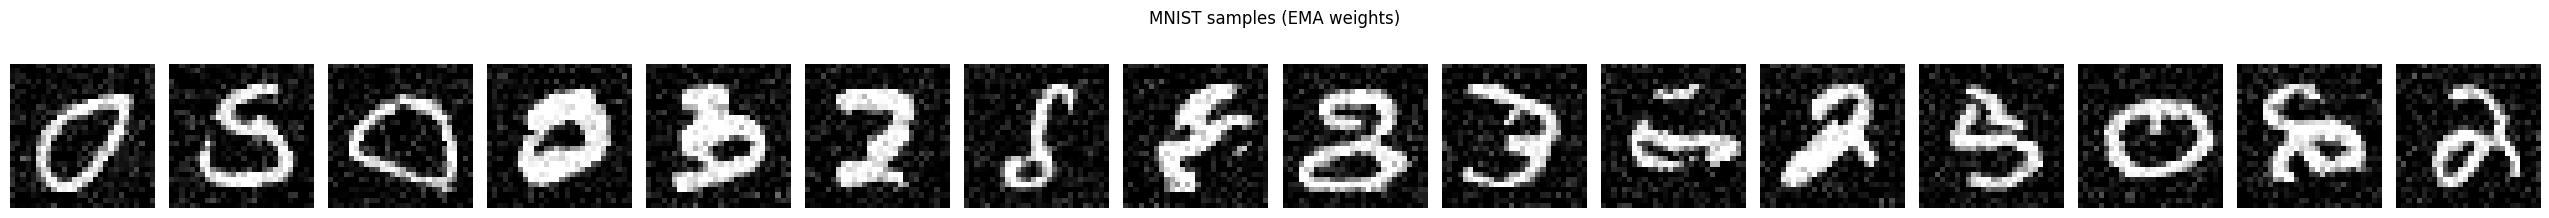

In [10]:
# ---- config (match training) ----
time_dim = 32
base_channels = 64
lambda_ = 1.0
t_min = 0.02

ema_weights_path = "mnist_unet_ema_weights.pth"  # <- from the stripper

# ---- build ----
sde = Forward(lambda_=lambda_)
ema_model = UNetScore(time_dim=time_dim, base_channels=base_channels).to(device)

ema_sd = torch.load(ema_weights_path, map_location=device)
ema_model.load_state_dict(ema_sd, strict=True)
ema_model.eval()

# ---- sample ----
samples = sample_reverse_euler_maruyama(
    ema_model, sde,
    num_steps=500,
    batch_size=16,
    device=device,
    t_min=t_min,
)

show_mnist_row(samples, title="MNIST samples (EMA weights)")
